In [1]:
import numpy as np
import keras
from keras.datasets import fashion_mnist
from time import time

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

Using TensorFlow backend.


### Данные:
Будем работать с датасетом [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). 

Переведем картинки в диапозон [-0.5, 0.5] (так удобнее добавлять шум). Так же разделим тестовую выборку на валидационную (80%) и совсем тестовую(20%). Выборку для обучения будем получать с помощью функции **get_train**. 

/home/fox/cloud/miniconda/envs/pytorch/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


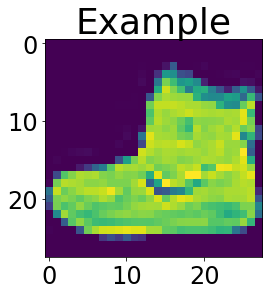

In [2]:
(X_init, y_init), (X_test, y_test) = fashion_mnist.load_data()
plt.title("Example")
plt.imshow(X_init[0])

X_init = X_init / 255 - 0.5
X_test = X_test / 255 - 0.5
permutation = np.random.permutation(np.arange(10000))
X_validate = X_test[permutation[:8000]]
y_validate = y_test[permutation[:8000]]
X_test = X_test[permutation[8000:]]
y_test = y_test[permutation[8000:]]
data = X_init, y_init, X_validate, y_validate, X_test, y_test

Определим в классе **Net** нашу нейронную сетку. Будем использовать 2 сверточных и 3 полносвязных слоя( не считая нормализации, пулинга, дропаута и релу). 

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 4, 3),
            nn.BatchNorm2d(4),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(4, 16, 3),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(2),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(400, 400),
            nn.BatchNorm1d(400),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(400, 400),
            nn.BatchNorm1d(400),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(400, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 400)
        x = self.fc(x)
        return x
    
def minibatch(X, y, batch_size=100):
    """
    Split data into batches
    
    Parameters:
        X: 2D np.array
            Data to be splitted
        y: 1D np.array
            Labels of input data
        batch_size: int(defaulte 100)
            Size of output batches
        
    Return:
        iterator of (X_batch, y_batch):
            Data splitted into batches
    """
    permutation = np.random.permutation(np.arange(y.size)).reshape(-1, batch_size)
    for indices in permutation:
        X_batch = Variable(torch.FloatTensor(X[indices]).unsqueeze(1))
        y_batch = Variable(torch.LongTensor(y[indices]))
        yield X_batch, y_batch
        
def get_train(X, y, output_size=10000, sigma=0):  
    """
    Rearrange train data
    
    Parameters:
        X: 2D np.array
            Data to be sampled from
        y: 1D np.array
            Labels of input data
        output_size: int(defaulte 10000)
            Size of output train data
        sigma: float(defaulte 0)
            Noise with sigma 'sigma' is added to train data
        
    Return:
        X_train: 2D np.array
            Train data
        y_train: 1D np.array
            Labels of train data
    """
    indices = np.random.choice(np.arange(X.shape[0]), output_size, replace=False)
    X_train = X[indices] + sigma * np.random.randn(output_size, *X.shape[1:3])
    y_train = y[indices]
    
    return X_train, y_train

def step(data, size=10000, sigma=0, epochs=50):
    """
    Perform one step of model training and evaluating
    
    Parameters:
        data: (X_train, y_train), (X_validate, y_validate), (X_test, y_test)
            Data for evaluation 
        X_init: 2D np.array
            Data to sample train data from
        y_init: 1D np.array
            Labels of data
        X_validate: 2D np.array
            Validation data
        y_validate: 1D np.array
            Labels of validation data
        X_test: 2D np.array
            Test data
        y_test: 1D np.array
            Labels of test data
        size: int(default 10000)
            Size of training data
        sigma: float(defaulte 0)
            Noise with sigma 'sigma' is added to train data
        epochs: int(defaulte 50)
            Number of epochs to train the model
    """    
    t0 = time()
    # get data
    X_init, y_init, X_validate, y_validate, X_test, y_test = data
    X_train, y_train = get_train(X_init, y_init, size, sigma)
    # inialize model
    model = Net()
    optimizer = torch.optim.Adam(model.parameters())
    loss_func = nn.CrossEntropyLoss()
    # save results here
    history, valid_list = [], []
    
    for epoch in range(epochs):
        t = time()
        # train model
        overall_loss = 0
        model.train()
        for X, y in minibatch(X_train, y_train):
            output = model(X)
            loss = loss_func(output, y)
            overall_loss += loss.data.numpy()
            loss.backward()                 
            optimizer.step()
            optimizer.zero_grad()
        history += [overall_loss]

        # validate model
        model.eval()    
        val = []
        for X, y in minibatch(X_validate, y_validate):
            output = model(X).data.numpy().argmax(axis=1)
            val += [output == y.data.numpy()]
        val_score = np.concatenate(val).mean()
        valid_list += [val_score]
        print("epoch %i with loss: %.2f, validation accuracy: %.3f, time: %.3f" \
              % (epoch, overall_loss, val_score, time() - t))

    # test model
    model.eval()    
    val = []
    for X, y in minibatch(X_test, y_test):
        output = model(X).data.numpy().argmax(axis=1)
        val += [output == y.data.numpy()]
    val_score = np.concatenate(val).mean()
    print("\nTest accuracy: %.3f" % val_score)
    print("Overall time:", time() - t0)
    
    #trans
    fig = plt.figure(figsize=(20, 10))
    fig.suptitle("Data size is %i, sigma is %.3f" % (size, sigma), fontsize=36)
    plt.subplot(121)
    plt.title("Train Loss over Epoch")
    plt.ylabel("Cross Entropy")
    plt.xlabel("Epoch")

    plt.plot(history) 
    plt.subplot(122)
    plt.title("Validation Accuracy over Epoch")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.plot(valid_list)
    plt.show()

Запустим нашу модель для случая, когда у нас нет шума и размер выборки 10000.

epoch 0 with loss: 166.90, validation accuracy: 0.709, time: 2.957
epoch 1 with loss: 109.00, validation accuracy: 0.754, time: 2.890
epoch 2 with loss: 96.50, validation accuracy: 0.773, time: 2.604
epoch 3 with loss: 89.51, validation accuracy: 0.779, time: 2.495
epoch 4 with loss: 86.88, validation accuracy: 0.790, time: 2.708
epoch 5 with loss: 83.33, validation accuracy: 0.795, time: 3.035
epoch 6 with loss: 80.62, validation accuracy: 0.798, time: 2.738
epoch 7 with loss: 78.28, validation accuracy: 0.808, time: 2.611
epoch 8 with loss: 77.43, validation accuracy: 0.808, time: 2.618
epoch 9 with loss: 75.41, validation accuracy: 0.813, time: 2.775
epoch 10 with loss: 73.48, validation accuracy: 0.818, time: 2.661
epoch 11 with loss: 73.38, validation accuracy: 0.820, time: 2.633
epoch 12 with loss: 73.41, validation accuracy: 0.821, time: 2.672
epoch 13 with loss: 73.19, validation accuracy: 0.822, time: 2.957
epoch 14 with loss: 72.71, validation accuracy: 0.816, time: 2.830
epo

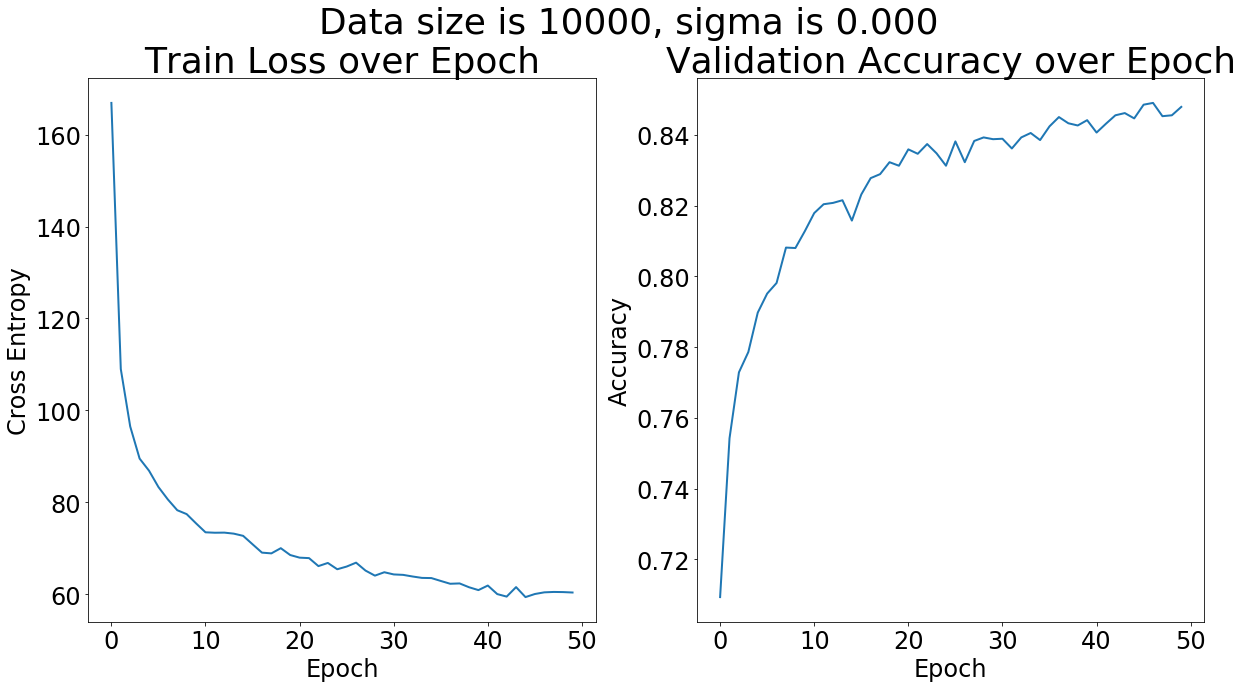

In [4]:
step(data)

Посмотрим, как влияет количество данных на обучение модели. Возьмем обучающие выборки размеров 200, 2000 и 20000. Получаем, что чем больше данных, чем быстрее учится модель и тем большую точность можно получить за то же число итераций.

epoch 0 with loss: 4.67, validation accuracy: 0.101, time: 0.465
epoch 1 with loss: 4.54, validation accuracy: 0.099, time: 0.546
epoch 2 with loss: 4.46, validation accuracy: 0.099, time: 0.515
epoch 3 with loss: 4.27, validation accuracy: 0.099, time: 0.478
epoch 4 with loss: 4.26, validation accuracy: 0.145, time: 0.544
epoch 5 with loss: 4.14, validation accuracy: 0.193, time: 0.494
epoch 6 with loss: 4.06, validation accuracy: 0.216, time: 0.546
epoch 7 with loss: 3.95, validation accuracy: 0.243, time: 0.502
epoch 8 with loss: 3.83, validation accuracy: 0.306, time: 0.494
epoch 9 with loss: 3.72, validation accuracy: 0.347, time: 0.493
epoch 10 with loss: 3.73, validation accuracy: 0.389, time: 0.534
epoch 11 with loss: 3.57, validation accuracy: 0.438, time: 0.546
epoch 12 with loss: 3.43, validation accuracy: 0.480, time: 0.571
epoch 13 with loss: 3.40, validation accuracy: 0.505, time: 0.472
epoch 14 with loss: 3.35, validation accuracy: 0.523, time: 0.488
epoch 15 with loss: 

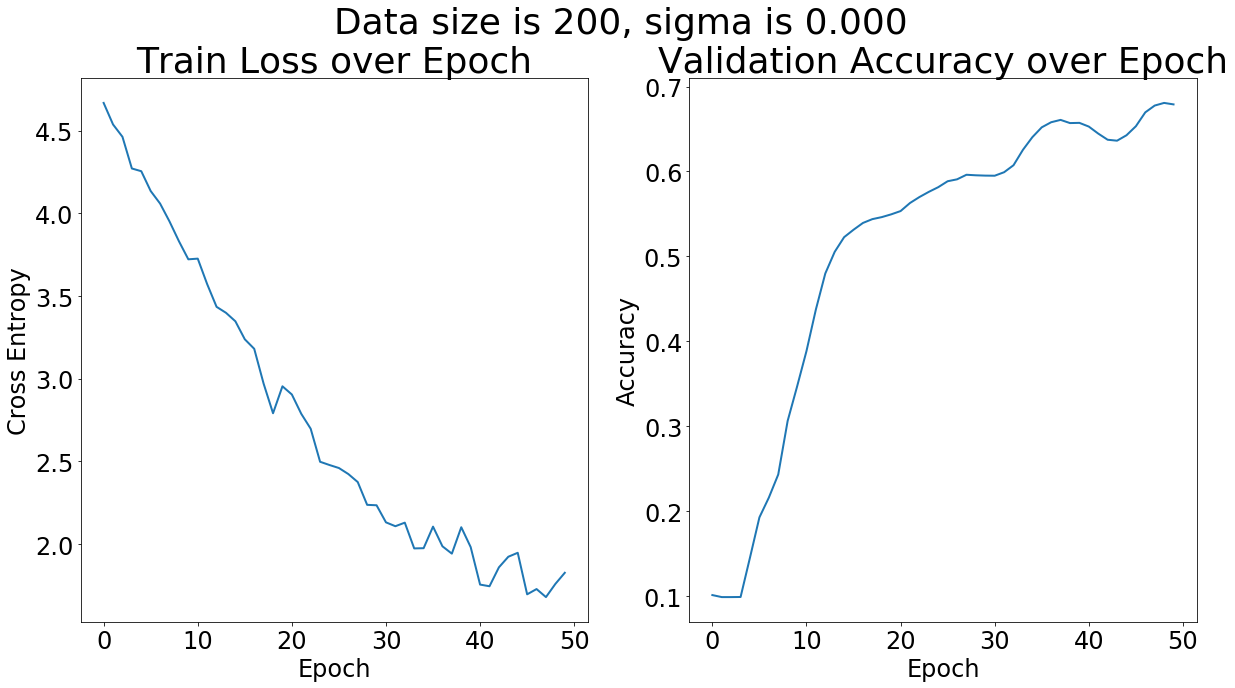

epoch 0 with loss: 44.26, validation accuracy: 0.334, time: 0.865
epoch 1 with loss: 37.06, validation accuracy: 0.603, time: 0.897
epoch 2 with loss: 30.16, validation accuracy: 0.665, time: 0.922
epoch 3 with loss: 25.62, validation accuracy: 0.716, time: 0.918
epoch 4 with loss: 22.93, validation accuracy: 0.731, time: 0.953
epoch 5 with loss: 21.76, validation accuracy: 0.731, time: 0.907
epoch 6 with loss: 20.66, validation accuracy: 0.737, time: 0.910
epoch 7 with loss: 19.83, validation accuracy: 0.750, time: 0.883
epoch 8 with loss: 19.84, validation accuracy: 0.750, time: 0.882
epoch 9 with loss: 18.71, validation accuracy: 0.758, time: 0.916
epoch 10 with loss: 18.50, validation accuracy: 0.750, time: 0.915
epoch 11 with loss: 18.52, validation accuracy: 0.763, time: 0.874
epoch 12 with loss: 17.96, validation accuracy: 0.764, time: 0.915
epoch 13 with loss: 17.32, validation accuracy: 0.767, time: 0.949
epoch 14 with loss: 17.26, validation accuracy: 0.772, time: 0.933
epoch

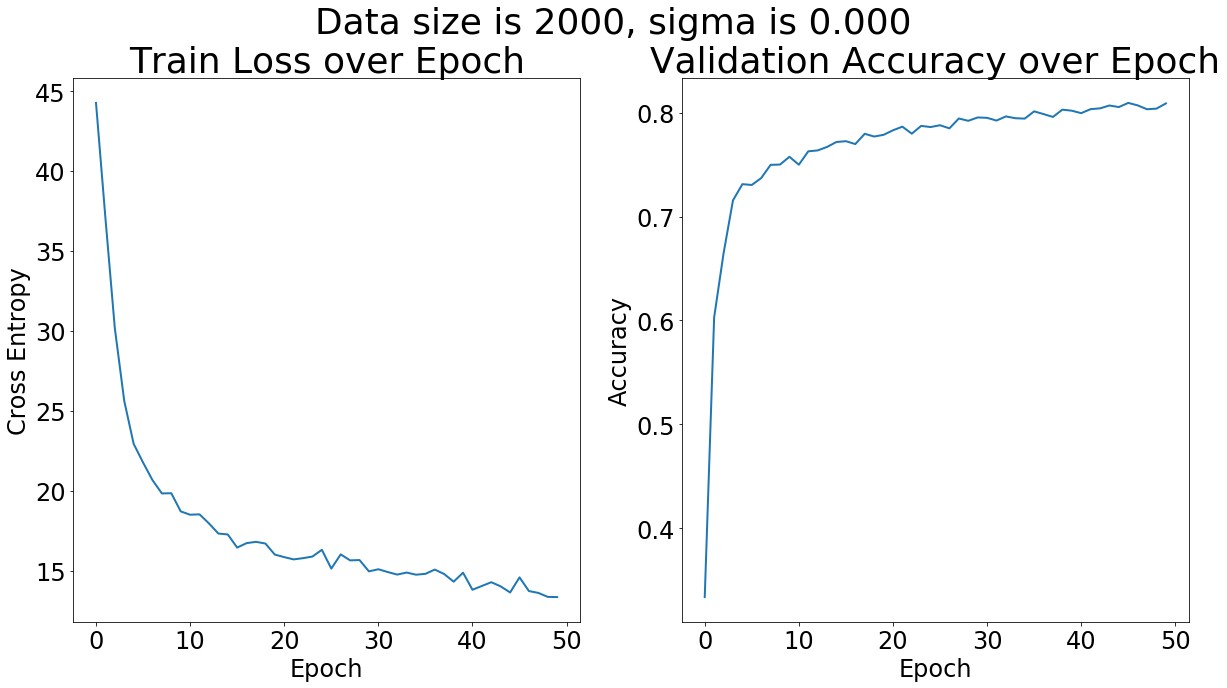

epoch 0 with loss: 264.33, validation accuracy: 0.751, time: 5.112
epoch 1 with loss: 181.88, validation accuracy: 0.766, time: 5.079
epoch 2 with loss: 166.82, validation accuracy: 0.786, time: 5.650
epoch 3 with loss: 154.08, validation accuracy: 0.790, time: 6.133
epoch 4 with loss: 150.68, validation accuracy: 0.804, time: 5.790
epoch 5 with loss: 147.02, validation accuracy: 0.812, time: 6.341
epoch 6 with loss: 142.85, validation accuracy: 0.817, time: 6.089
epoch 7 with loss: 138.64, validation accuracy: 0.814, time: 6.029
epoch 8 with loss: 138.00, validation accuracy: 0.822, time: 5.165
epoch 9 with loss: 136.02, validation accuracy: 0.825, time: 5.336
epoch 10 with loss: 132.51, validation accuracy: 0.826, time: 5.836
epoch 11 with loss: 134.37, validation accuracy: 0.829, time: 5.199
epoch 12 with loss: 131.69, validation accuracy: 0.832, time: 5.115
epoch 13 with loss: 128.98, validation accuracy: 0.833, time: 5.454
epoch 14 with loss: 130.78, validation accuracy: 0.831, ti

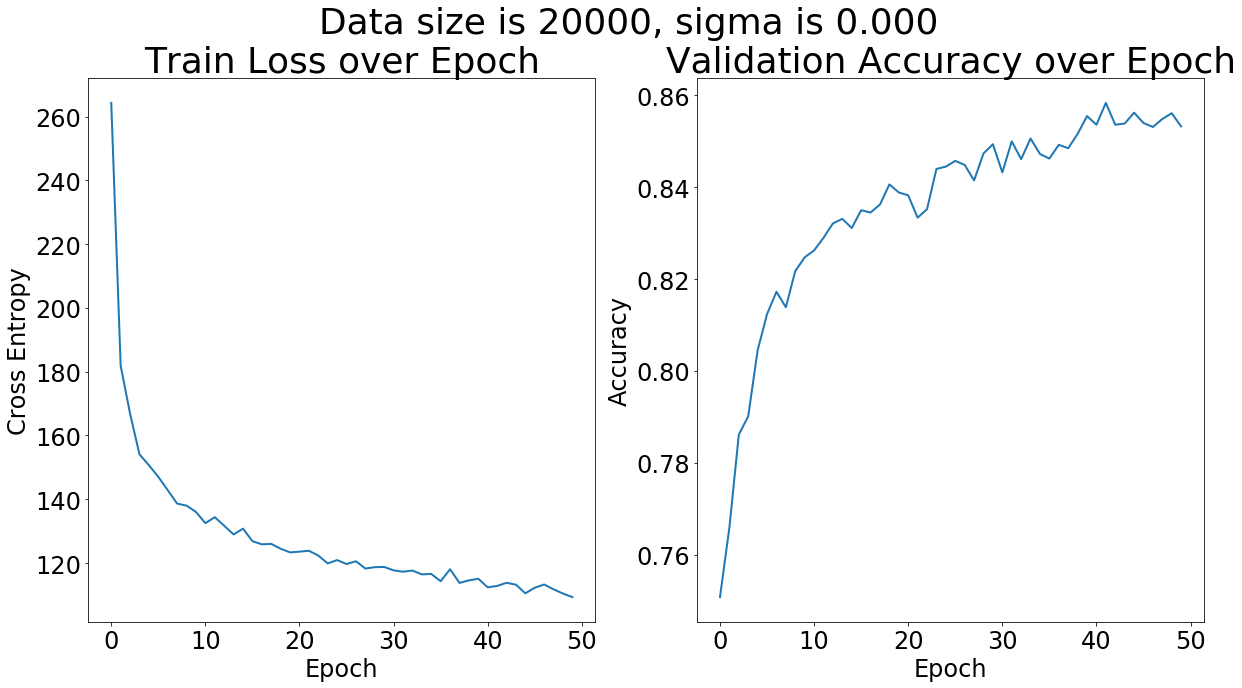

In [5]:
train_sizes = [200, 2000, 20000]
for tsize in train_sizes:
    step(data, size=tsize)

Рассотрим, как ведет себя модель, если к обучающей выборки добавить белый шум. Будем использовать нормальное распределение с сигмами 0.25, 0.5, 0.75. Из получившихся графиков видно, что чем меньше шум, тем быстрее и лучше идет обучение модели.

epoch 0 with loss: 186.54, validation accuracy: 0.651, time: 2.352
epoch 1 with loss: 117.70, validation accuracy: 0.692, time: 2.473
epoch 2 with loss: 102.91, validation accuracy: 0.704, time: 2.432
epoch 3 with loss: 95.45, validation accuracy: 0.719, time: 2.409
epoch 4 with loss: 94.28, validation accuracy: 0.748, time: 2.411
epoch 5 with loss: 89.44, validation accuracy: 0.729, time: 2.323
epoch 6 with loss: 87.28, validation accuracy: 0.756, time: 2.420
epoch 7 with loss: 85.74, validation accuracy: 0.759, time: 2.371
epoch 8 with loss: 84.47, validation accuracy: 0.761, time: 2.446
epoch 9 with loss: 83.39, validation accuracy: 0.774, time: 2.412
epoch 10 with loss: 81.76, validation accuracy: 0.772, time: 2.492
epoch 11 with loss: 81.12, validation accuracy: 0.776, time: 2.405
epoch 12 with loss: 80.53, validation accuracy: 0.768, time: 2.536
epoch 13 with loss: 79.23, validation accuracy: 0.779, time: 2.527
epoch 14 with loss: 80.02, validation accuracy: 0.785, time: 2.460
ep

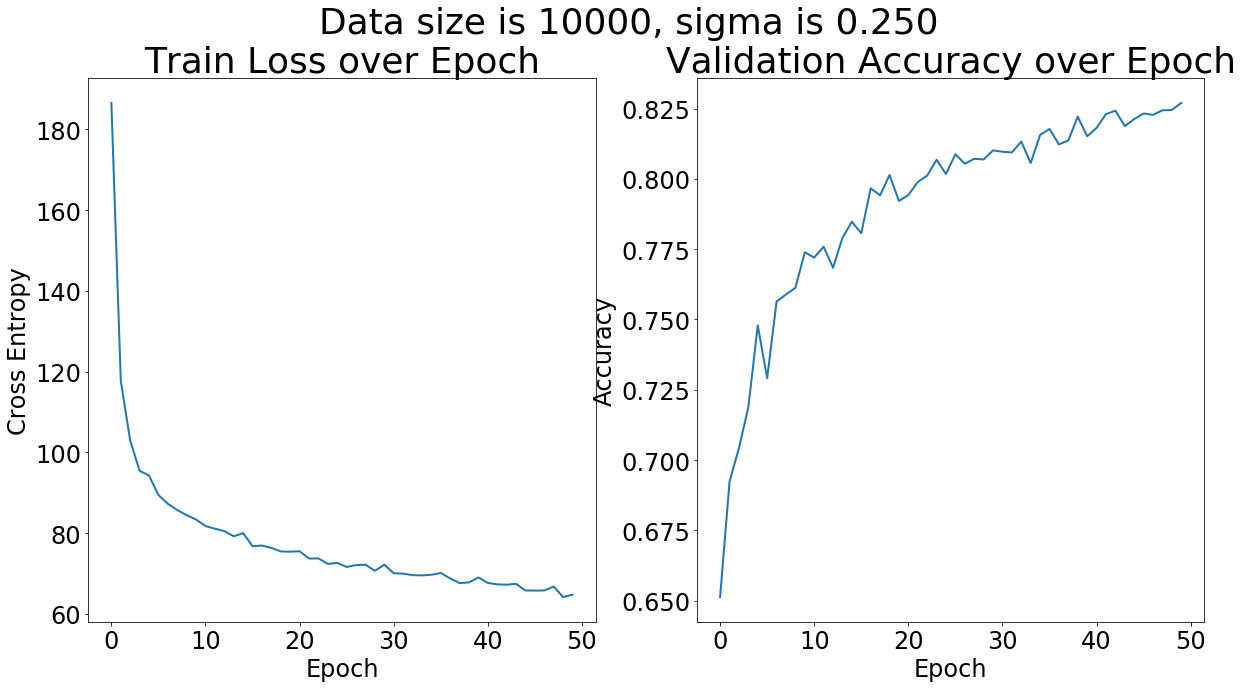

epoch 0 with loss: 192.61, validation accuracy: 0.607, time: 2.255
epoch 1 with loss: 127.25, validation accuracy: 0.690, time: 2.230
epoch 2 with loss: 112.47, validation accuracy: 0.698, time: 2.263
epoch 3 with loss: 106.07, validation accuracy: 0.708, time: 2.230
epoch 4 with loss: 103.14, validation accuracy: 0.723, time: 2.353
epoch 5 with loss: 101.07, validation accuracy: 0.732, time: 2.742
epoch 6 with loss: 98.07, validation accuracy: 0.729, time: 2.535
epoch 7 with loss: 96.15, validation accuracy: 0.743, time: 2.560
epoch 8 with loss: 94.12, validation accuracy: 0.744, time: 2.379
epoch 9 with loss: 92.35, validation accuracy: 0.746, time: 2.359
epoch 10 with loss: 92.67, validation accuracy: 0.742, time: 2.393
epoch 11 with loss: 91.75, validation accuracy: 0.755, time: 2.384
epoch 12 with loss: 90.21, validation accuracy: 0.747, time: 2.399
epoch 13 with loss: 89.25, validation accuracy: 0.757, time: 2.387
epoch 14 with loss: 88.97, validation accuracy: 0.749, time: 2.517

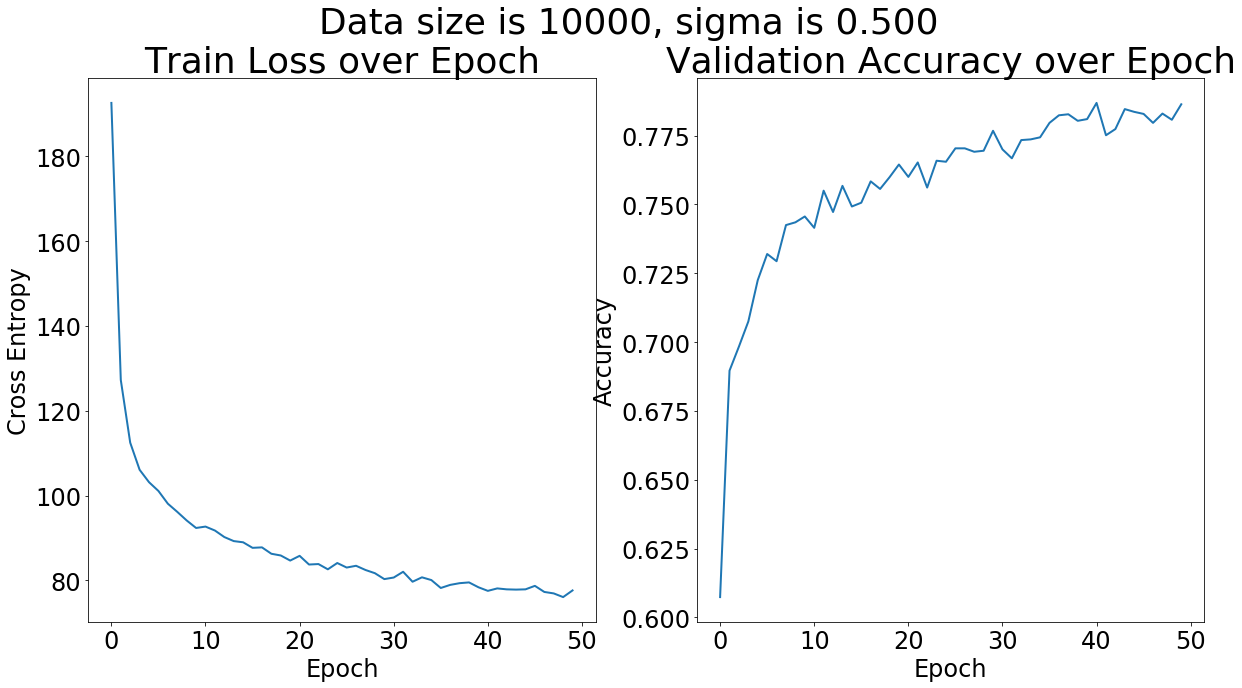

epoch 0 with loss: 209.75, validation accuracy: 0.519, time: 2.355
epoch 1 with loss: 147.30, validation accuracy: 0.558, time: 2.413
epoch 2 with loss: 124.82, validation accuracy: 0.669, time: 2.384
epoch 3 with loss: 117.31, validation accuracy: 0.673, time: 2.203
epoch 4 with loss: 112.66, validation accuracy: 0.696, time: 2.219
epoch 5 with loss: 110.69, validation accuracy: 0.697, time: 2.387
epoch 6 with loss: 108.75, validation accuracy: 0.704, time: 2.697
epoch 7 with loss: 106.47, validation accuracy: 0.713, time: 2.840
epoch 8 with loss: 105.59, validation accuracy: 0.707, time: 2.631
epoch 9 with loss: 102.36, validation accuracy: 0.718, time: 2.997
epoch 10 with loss: 102.39, validation accuracy: 0.713, time: 2.792
epoch 11 with loss: 101.23, validation accuracy: 0.732, time: 2.909
epoch 12 with loss: 101.24, validation accuracy: 0.727, time: 2.508
epoch 13 with loss: 102.23, validation accuracy: 0.729, time: 2.549
epoch 14 with loss: 98.92, validation accuracy: 0.732, tim

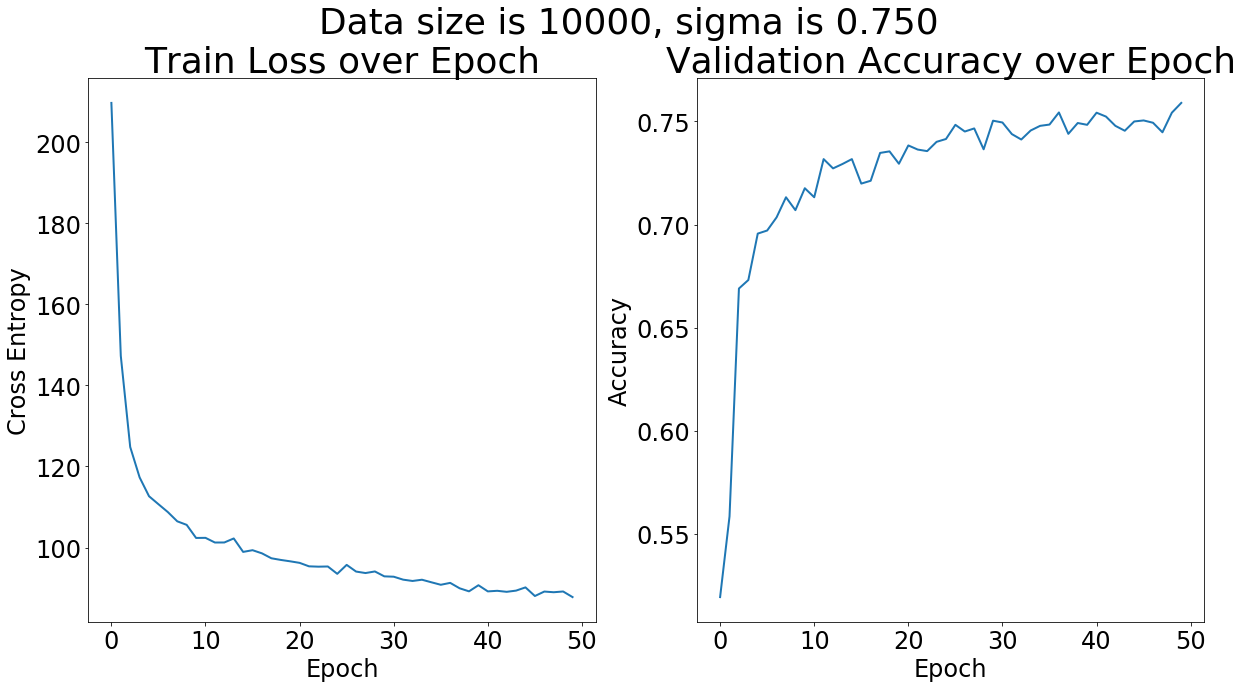

In [6]:
noise = [0.25, 0.5, 0.75]
for nsigma in noise:
    step(data, sigma=nsigma)